In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from skimage.segmentation import felzenszwalb
from sklearn.cluster import spectral_clustering, SpectralClustering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import rgb_to_hsv
from scipy import misc
from skimage.metrics import adapted_rand_error, variation_of_information
from scipy import ndimage as ndi
from sklearn.feature_extraction import image
import cv2
from PIL import Image
import numpy as np
import os
import time
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

# Helper Functions

In [94]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [95]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# EDA: K-means

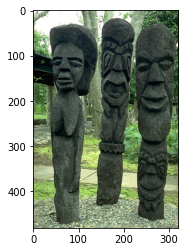

In [90]:
# Read Images
img = plt.imread('data/images/train/101085.jpg')

# Output Images
plt.imshow(img)

In [91]:
print(img.shape)

(481, 321, 3)


In [92]:
data = img / 255.0 # use 0...1 scale
data = data.reshape(321 * 481, 3)
print(data.shape)

(154401, 3)


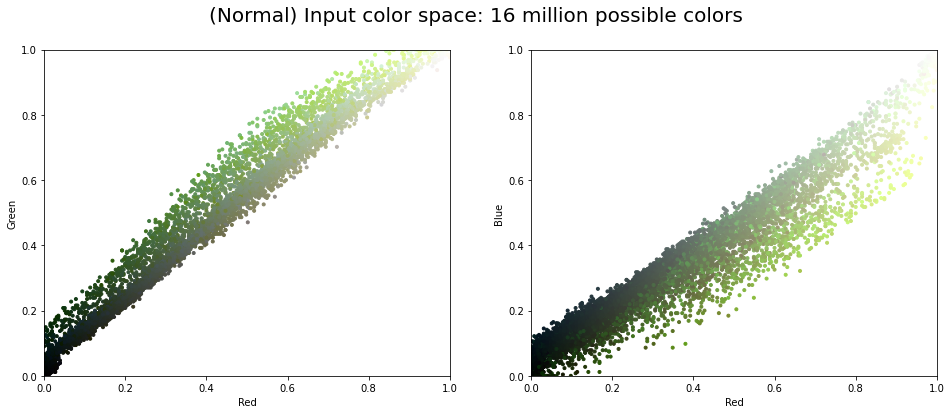

In [96]:
plot_pixels(data, title='(Normal) Input color space: 16 million possible colors')

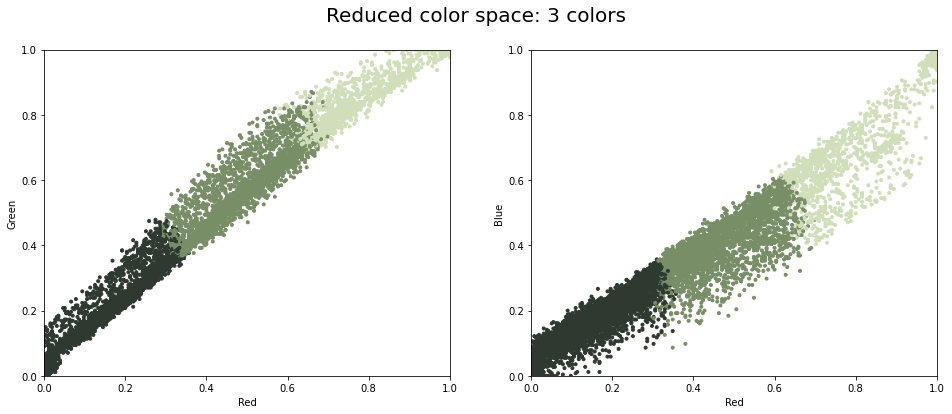

In [97]:
kmeans = KMeans(3)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 3 colors")

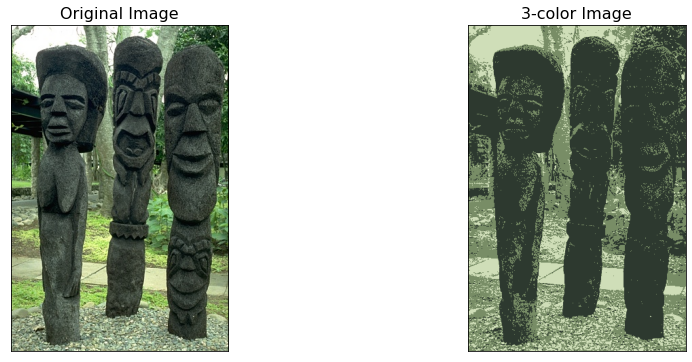

In [98]:
img_recolored = new_colors.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(img_recolored)
ax[1].set_title('3-color Image', size=16);

F:          0.32457126254134816
Error:      0.6754287374586518
Precision:  0.7901582033986768
Recall:     0.20423144525592332
Splits:     0.6478835303803413
Merges:     3.6560451201787063


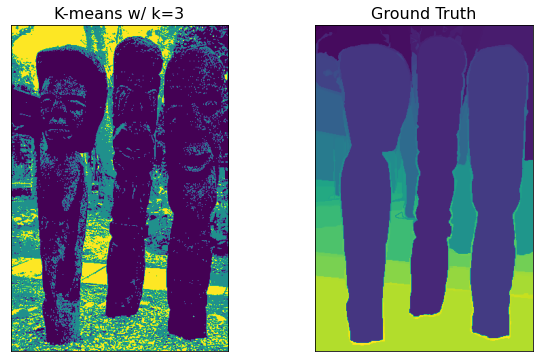

In [115]:
img_test = cv2.imread('data/images/train/101085.jpg')

data_test = img_test / 255.0
data_test = data_test.reshape(321 * 481, 3)

kmeans_test = KMeans(3)
kmeans_test.fit(data_test)
new_colors_test = kmeans_test.cluster_centers_[kmeans_test.predict(data_test)]
img_recolored_test = new_colors_test.reshape(img_test.shape)[:,:,1]

img_recolored_test = (img_recolored_test * 255).astype(int)

img_true_test = cv2.imread('data/human/101085.bmp')
img_true_test = img_true_test[:,:,1]
img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)

error, precision, recall = adapted_rand_error(img_true_test, img_recolored_test)
splits, merges = variation_of_information(img_true_test, img_recolored_test)
f_score = 2 * (precision * recall) / (precision + recall)
print('F:          ' + str(f_score))
print('Error:      ' + str(error))
print('Precision:  ' + str(precision))
print('Recall:     ' + str(recall))
print('Splits:     ' + str(splits))
print('Merges:     ' + str(merges))

fig, ax = plt.subplots(1, 2, figsize=(10, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(img_recolored_test)
ax[0].set_title('K-means w/ k=3', size=16)
ax[1].imshow(img_true_test)
ax[1].set_title('Ground Truth', size=16);

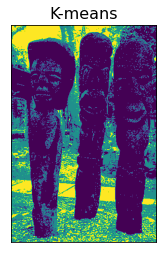

In [117]:
plt.imshow(img_recolored_test)
plt.title('K-means', size=16)
plt.xticks([])
plt.yticks([])
plt.show()

# EDA: Efficient Graph Based Search (Felzenszwalb)

F:          0.6634238019007989
Error:      0.33657619809920114
Precision:  0.6798343687243621
Recall:     0.6477868326711879
Splits:     1.2144740335374817
Merges:     1.1570829234308628


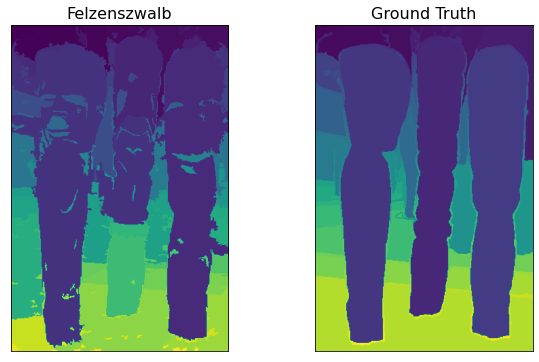

In [113]:
img = Image.open('data/images/train/101085.jpg')

img_test = felzenszwalb(img, sigma=0.6, scale=600)

# Ground truth image
img_true_test = Image.open('data/human/101085.bmp')
img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)

# Evaluate
error, precision, recall = adapted_rand_error(img_true_test, img_test)
splits, merges = variation_of_information(img_true_test, img_test)
f_score = 2 * (precision * recall) / (precision + recall)
print('F:          ' + str(f_score))
print('Error:      ' + str(error))
print('Precision:  ' + str(precision))
print('Recall:     ' + str(recall))
print('Splits:     ' + str(splits))
print('Merges:     ' + str(merges))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(img_test)
ax[0].set_title('Felzenszwalb', size=16)
ax[1].imshow(img_true_test)
ax[1].set_title('Ground Truth', size=16);

# EDA: Spectral Clustering

In [101]:
def run_spectral_clustering(img, n_clusters):
    size = img.size
    
    # Resize the image to speed up clustering
    basewidth = 50
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)

    # Convert to graph and perform clustering
    img_seg = img.convert('L')
    img_seg = np.asarray(img_seg).astype(float)/255.0
    graph = image.img_to_graph(img_seg)
    beta = 5
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps
    labels = spectral_clustering(graph, n_clusters=n_clusters, assign_labels='kmeans', random_state=1)
    labels = labels.reshape(img_seg.shape)
    img_seg = labels.copy()

    # Resize the segmentation
    img_seg = img_seg / (n_clusters - 1)
    img_seg = (img_seg*255).astype(int)
    img_seg = Image.fromarray(img_seg)
    img_seg = img_seg.resize((size[0], size[1]), Image.ANTIALIAS)
    img_seg = np.array(img_seg)
    max_pixel = np.amax(img_seg)
    min_pixel = np.amin(img_seg)
    img_seg = (img_seg + abs(min_pixel)) / (max_pixel + abs(min_pixel))
    img_seg = (img_seg * 255).astype(int)
    
    return img_seg

F:          0.30268372517577036
Error:      0.6973162748242296
Precision:  0.22554086191913844
Recall:     0.4600301141546796
Splits:     3.2086786953252058
Merges:     1.9361825851846266


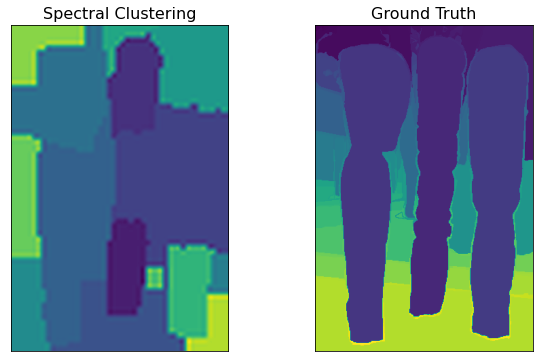

In [107]:
img = Image.open('data/images/train/101085.jpg')

img_seg = run_spectral_clustering(img, 15)

# Ground truth image
img_true_test = Image.open('data/human/101085.bmp')
img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)

# Evaluate
error, precision, recall = adapted_rand_error(img_true_test, img_seg)
splits, merges = variation_of_information(img_true_test, img_seg)
f_score = 2 * (precision * recall) / (precision + recall)
print('F:          ' + str(f_score))
print('Error:      ' + str(error))
print('Precision:  ' + str(precision))
print('Recall:     ' + str(recall))
print('Splits:     ' + str(splits))
print('Merges:     ' + str(merges))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(img_seg)
ax[0].set_title('Spectral Clustering', size=16)
ax[1].imshow(img_true_test)
ax[1].set_title('Ground Truth', size=16);

# Train: K-Means

1/ 10
2/ 10
3/ 10
4/ 10
5/ 10
6/ 10
7/ 10
8/ 10
9/ 10
10/ 10
Time elapsed: 1412.4256052970886


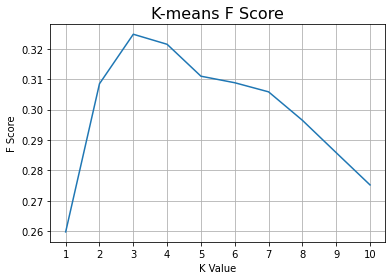

In [103]:
path = 'data/images/train/'
human_path = 'data/human/'
avg_f_score = []

start_time = time.time()

for k in range(1, 11):
    print(str(k) + '/ 10')
    error_list = []
    for filename in os.listdir(path):
        img_test = cv2.imread(path + filename)
        img_true_test = cv2.imread(human_path + filename[:-4] + '.bmp')
        img_true_test = img_true_test[:,:,1]
        img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)
        data_test = img_test / 255.0
        data_test = data_test.reshape(321 * 481, 3)
        kmeans_test = KMeans(k)
        kmeans_test.fit(data_test)
        new_colors_test = kmeans_test.cluster_centers_[kmeans_test.predict(data_test)]
        img_recolored_test = new_colors_test.reshape(img_test.shape)[:,:,1]
        img_recolored_test = (img_recolored_test * 255).astype(int)
        error, precision, recall = adapted_rand_error(img_true_test, img_recolored_test)
        error_list.append(error)
    avg_f_score.append(1 - np.mean(error_list))

print('Time elapsed: ' + str(time.time() - start_time))
plt.plot(range(1,11), avg_f_score)
plt.title('K-means F Score', size=16)
plt.xlabel('K Value')
plt.ylabel('F Score')
plt.xticks(range(1,11))
plt.grid()
plt.show()

# Train: Spectral Clustering

2/ 20
3/ 20
4/ 20
5/ 20
6/ 20
7/ 20
8/ 20
9/ 20
10/ 20
11/ 20
12/ 20
13/ 20
14/ 20
15/ 20
16/ 20
17/ 20
18/ 20
19/ 20
20/ 20
Time elapsed: 1155.2993323802948


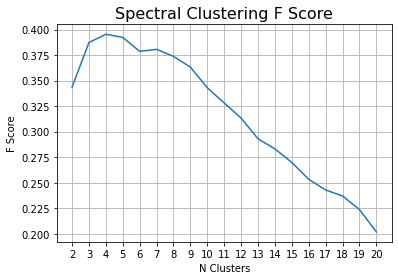

In [77]:
path = 'data/images/train/'
human_path = 'data/human/'
avg_f_score = []

start_time = time.time()

for n in range(2, 21):
    print(str(n) + '/ 20')
    error_list = []
    for filename in os.listdir(path):
        img = Image.open(path + filename)
        img_seg = run_spectral_clustering(img, n_clusters=n)
        img_true_test = Image.open(human_path + filename[:-4] + '.bmp')
        img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)
        error, precision, recall = adapted_rand_error(img_true_test, img_seg)
        error_list.append(error)
    avg_f_score.append(1 - np.mean(error_list))

print('Time elapsed: ' + str(time.time() - start_time))
plt.plot(range(2,21), avg_f_score)
plt.title('Spectral Clustering F Score', size=16)
plt.xlabel('N Clusters')
plt.ylabel('F Score')
plt.xticks(range(2,21))
plt.grid()
plt.show()

# Train: Felzenszwalb

1/ 21
2/ 21
3/ 21
4/ 21
5/ 21
6/ 21
7/ 21
8/ 21
9/ 21
10/ 21
11/ 21
12/ 21
13/ 21
14/ 21
15/ 21
16/ 21
17/ 21
18/ 21
19/ 21
20/ 21
21/ 21
Time elapsed: 475.29935574531555


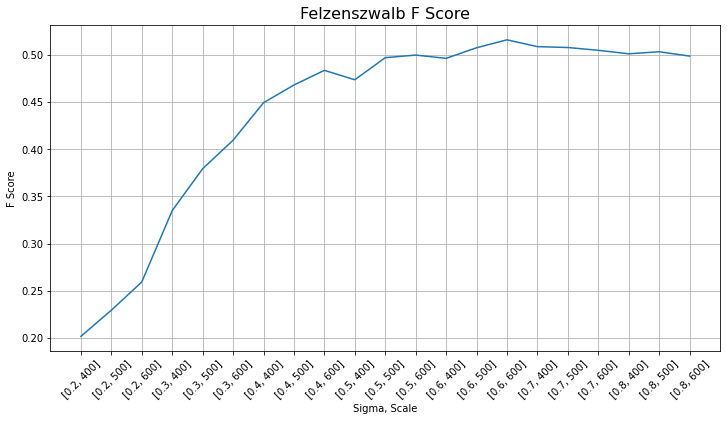

In [70]:
path = 'data/images/train/'
human_path = 'data/human/'
avg_f_score = []
x_list = []

start_time = time.time()

i = 0
for sigma in range(2, 9):
    sigma = sigma / 10
    for scale in [400, 500, 600]:
        i += 1
        print(str(i) + '/ 21')
        x_list.append(str([sigma,scale]))
        error_list = []
        for filename in os.listdir(path):
            img = Image.open(path + filename)
            img_test = felzenszwalb(img, sigma=sigma, scale=scale)
            img_true_test = Image.open(human_path + filename[:-4] + '.bmp')
            img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)
            error, precision, recall = adapted_rand_error(img_true_test, img_test)
            error_list.append(error)
        avg_f_score.append(1 - np.mean(error_list))

print('Time elapsed: ' + str(time.time() - start_time))
plt.figure(figsize=(12, 6))
plt.plot(x_list, avg_f_score)
plt.title('Felzenszwalb F Score', size=16)
plt.xlabel('Sigma, Scale')
plt.ylabel('F Score')
plt.xticks(rotation = 45)
plt.grid()
plt.show()

# Test K-means

In [104]:
path = 'data/images/test/'
human_path = 'data/human/'
error_list = []

start_time = time.time()

# iterate through the names of contents of the folder
for filename in os.listdir(path):
    img_test = cv2.imread(path + filename)
    img_true_test = cv2.imread(human_path + filename[:-4] + '.bmp')
    img_true_test = img_true_test[:,:,1]
    img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)
    data_test = img_test / 255.0
    data_test = data_test.reshape(321 * 481, 3)
    kmeans_test = KMeans(3)
    kmeans_test.fit(data_test)
    new_colors_test = kmeans_test.cluster_centers_[kmeans_test.predict(data_test)]
    img_recolored_test = new_colors_test.reshape(img_test.shape)[:,:,1]
    img_recolored_test = (img_recolored_test * 255).astype(int)
    error, precision, recall = adapted_rand_error(img_true_test, img_recolored_test)
    error_list.append(error)

print('Time elapsed: ' + str(time.time() - start_time))
print('Average F score:     ' + str(1 - np.mean(error_list)))

Time elapsed: 31.982605934143066
Average F score:     0.31562501896160156


# Test: Felzenswalb

In [105]:
path = 'data/images/test/'
human_path = 'data/human/'
error_list = []

start_time = time.time()

for filename in os.listdir(path):
    img = Image.open(path + filename)

    img_test = felzenszwalb(img, sigma=0.6, scale=600)

    # Ground truth image
    img_true_test = Image.open(human_path + filename[:-4] + '.bmp')
    img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)

    # Evaluate
    error, precision, recall = adapted_rand_error(img_true_test, img_test)
    error_list.append(error)

print('Time elapsed: ' + str(time.time() - start_time))
print('Average F score:     ' + str(1 - np.mean(error_list)))

Time elapsed: 9.472003698348999
Average F score:     0.46331494931736295


# Test Spectral Clustering

In [106]:
path = 'data/images/test/'
human_path = 'data/human/'
error_list = []

start_time = time.time()

for filename in os.listdir(path):
    img = Image.open(path + filename)

    img_seg = run_spectral_clustering(img, n_clusters=4)
    
    # Ground truth image
    img_true_test = Image.open(human_path + filename[:-4] + '.bmp')
    img_true_test = felzenszwalb(img_true_test, sigma=0.2, scale=300)

    # Evaluate
    error, precision, recall = adapted_rand_error(img_true_test, img_seg)
    error_list.append(error)

print('Time elapsed: ' + str(time.time() - start_time))
print('Average F score:     ' + str(1 - np.mean(error_list)))

Time elapsed: 22.120484352111816
Average F score:     0.38369737805955173
